In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
import keras
from keras import layers
from keras.layers import *
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from scipy.io import loadmat

Using TensorFlow backend.


In [2]:
data = loadmat('jaffe_mean_data.mat')['jaffe_mean_data']

In [3]:
data = data.reshape((181,256,256,1))

In [4]:
label = loadmat('cl_label.mat')['cl_label']

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2,random_state=0)

In [6]:
print('Training: ',X_train.shape)

Training:  (144, 256, 256, 1)


In [7]:
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D

In [8]:
from keras.models import Sequential

In [9]:
def get_nn_model():
    model = Sequential()
    model.add(MaxPooling2D(pool_size = (4,4), strides=None,input_shape=(256,256,1)))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [10]:
def get_cnn_model():
    model = Sequential()
    model.add(Convolution2D(64, (3, 3), padding='same',input_shape=(256,256,1)))
    model.add(Convolution2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [11]:
cnn_model = get_cnn_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
nn_model = get_nn_model()

In [13]:
from keras.preprocessing.image import ImageDataGenerator 

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [15]:
from keras import backend as K

In [16]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [17]:
def train_cnn_model(model):
    filepath='../opt/jaffe-cnn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 200
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    validation_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [18]:
def train_nn_model(model):
    filepath='../opt/jaffe-nn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 200
    model.compile(loss='categorical_crossentropy',
             optimizer='sgd',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    validation_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [19]:
 cnn_history, cnn_model = train_cnn_model(cnn_model)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
5/4 [=================================] - 18s 4s/step - loss: 2.8268 - fbeta: 0.1186 - acc: 0.2054 - val_loss: 7.7362 - val_fbeta: 0.1081 - val_acc: 0.1081

Epoch 00001: saving model to ../opt/jaffe-cnn/Model.01-0.1081.hdf5

Epoch 00001: saving model to ../opt/jaffe-cnn/Model.01-0.1081.hdf5
Epoch 2/200
5/4 [=================================] - 2s 346ms/step - loss: 2.1875 - fbeta: 0.1366 - acc: 0.2870 - val_loss: 13.9039 - val_fbeta: 0.1351 - val_acc: 0.1351

Epoch 00002: saving model to ../opt/jaffe-cnn/Model.02-0.1351.hdf5

Epoch 00002: saving model to ../opt/jaffe-cnn/Model.02-0.1351.hdf5
Epoch 3/200
5/4 [=================================] - 2s 346ms/step - loss: 2.1551 - fbeta: 0.1366 - acc: 0.2731 - val_loss: 7.4060 - val_fbeta: 0.3243 - val_acc: 0.3243

Epoch 00003: saving model to ../opt/jaffe-cnn/Model.03-0.3243.hdf5

Epoch 00003: saving model to ../opt/jaffe-cnn/Model.03-0.3243.hdf5
Epoch 4/200
5/4 [==================

Epoch 27/200
5/4 [=================================] - 2s 342ms/step - loss: 0.3029 - fbeta: 0.8814 - acc: 0.9120 - val_loss: 2.2562 - val_fbeta: 0.2432 - val_acc: 0.3514

Epoch 00027: saving model to ../opt/jaffe-cnn/Model.27-0.3514.hdf5

Epoch 00027: saving model to ../opt/jaffe-cnn/Model.27-0.3514.hdf5
Epoch 28/200
5/4 [=================================] - 2s 344ms/step - loss: 0.3882 - fbeta: 0.8559 - acc: 0.8686 - val_loss: 1.5799 - val_fbeta: 0.3243 - val_acc: 0.4865

Epoch 00028: saving model to ../opt/jaffe-cnn/Model.28-0.4865.hdf5

Epoch 00028: saving model to ../opt/jaffe-cnn/Model.28-0.4865.hdf5
Epoch 29/200
5/4 [=================================] - 2s 345ms/step - loss: 0.2328 - fbeta: 0.9132 - acc: 0.9196 - val_loss: 1.1614 - val_fbeta: 0.5676 - val_acc: 0.6757

Epoch 00029: saving model to ../opt/jaffe-cnn/Model.29-0.6757.hdf5

Epoch 00029: saving model to ../opt/jaffe-cnn/Model.29-0.6757.hdf5
Epoch 30/200
5/4 [=================================] - 2s 343ms/step - loss: 0.


Epoch 00053: saving model to ../opt/jaffe-cnn/Model.53-0.8108.hdf5
Epoch 54/200
5/4 [=================================] - 2s 338ms/step - loss: 0.0850 - fbeta: 0.9745 - acc: 0.9745 - val_loss: 0.6288 - val_fbeta: 0.7297 - val_acc: 0.7838

Epoch 00054: saving model to ../opt/jaffe-cnn/Model.54-0.7838.hdf5

Epoch 00054: saving model to ../opt/jaffe-cnn/Model.54-0.7838.hdf5
Epoch 55/200
5/4 [=================================] - 2s 342ms/step - loss: 0.0888 - fbeta: 0.9653 - acc: 0.9769 - val_loss: 0.6165 - val_fbeta: 0.7297 - val_acc: 0.7838

Epoch 00055: saving model to ../opt/jaffe-cnn/Model.55-0.7838.hdf5

Epoch 00055: saving model to ../opt/jaffe-cnn/Model.55-0.7838.hdf5
Epoch 56/200
5/4 [=================================] - 2s 339ms/step - loss: 0.0915 - fbeta: 0.9757 - acc: 0.9757 - val_loss: 0.5655 - val_fbeta: 0.7568 - val_acc: 0.8108

Epoch 00056: saving model to ../opt/jaffe-cnn/Model.56-0.8108.hdf5

Epoch 00056: saving model to ../opt/jaffe-cnn/Model.56-0.8108.hdf5
Epoch 57/20


Epoch 00080: saving model to ../opt/jaffe-cnn/Model.80-0.8919.hdf5

Epoch 00080: saving model to ../opt/jaffe-cnn/Model.80-0.8919.hdf5
Epoch 81/200
5/4 [=================================] - 2s 343ms/step - loss: 0.1363 - fbeta: 0.9514 - acc: 0.9693 - val_loss: 0.3657 - val_fbeta: 0.8649 - val_acc: 0.8919

Epoch 00081: saving model to ../opt/jaffe-cnn/Model.81-0.8919.hdf5

Epoch 00081: saving model to ../opt/jaffe-cnn/Model.81-0.8919.hdf5
Epoch 82/200
5/4 [=================================] - 2s 340ms/step - loss: 0.0955 - fbeta: 0.9757 - acc: 0.9757 - val_loss: 0.3407 - val_fbeta: 0.9189 - val_acc: 0.9189

Epoch 00082: saving model to ../opt/jaffe-cnn/Model.82-0.9189.hdf5

Epoch 00082: saving model to ../opt/jaffe-cnn/Model.82-0.9189.hdf5
Epoch 83/200
5/4 [=================================] - 2s 342ms/step - loss: 0.0989 - fbeta: 0.9630 - acc: 0.9693 - val_loss: 0.3375 - val_fbeta: 0.8649 - val_acc: 0.9189

Epoch 00083: saving model to ../opt/jaffe-cnn/Model.83-0.9189.hdf5

Epoch 0008

5/4 [=================================] - 2s 343ms/step - loss: 0.0946 - fbeta: 0.9682 - acc: 0.9745 - val_loss: 0.3262 - val_fbeta: 0.8649 - val_acc: 0.9459

Epoch 00107: saving model to ../opt/jaffe-cnn/Model.107-0.9459.hdf5

Epoch 00107: saving model to ../opt/jaffe-cnn/Model.107-0.9459.hdf5
Epoch 108/200
5/4 [=================================] - 2s 344ms/step - loss: 0.0905 - fbeta: 0.9641 - acc: 0.9641 - val_loss: 0.3089 - val_fbeta: 0.8919 - val_acc: 0.9459

Epoch 00108: saving model to ../opt/jaffe-cnn/Model.108-0.9459.hdf5

Epoch 00108: saving model to ../opt/jaffe-cnn/Model.108-0.9459.hdf5
Epoch 109/200
5/4 [=================================] - 2s 342ms/step - loss: 0.0876 - fbeta: 0.9757 - acc: 0.9873 - val_loss: 0.2982 - val_fbeta: 0.9189 - val_acc: 0.9459

Epoch 00109: saving model to ../opt/jaffe-cnn/Model.109-0.9459.hdf5

Epoch 00109: saving model to ../opt/jaffe-cnn/Model.109-0.9459.hdf5
Epoch 110/200
5/4 [=================================] - 2s 338ms/step - loss: 0.0723


Epoch 00133: saving model to ../opt/jaffe-cnn/Model.133-0.9459.hdf5

Epoch 00133: saving model to ../opt/jaffe-cnn/Model.133-0.9459.hdf5
Epoch 134/200
5/4 [=================================] - 2s 339ms/step - loss: 0.0793 - fbeta: 0.9884 - acc: 0.9884 - val_loss: 0.2906 - val_fbeta: 0.9730 - val_acc: 0.9730

Epoch 00134: saving model to ../opt/jaffe-cnn/Model.134-0.9730.hdf5

Epoch 00134: saving model to ../opt/jaffe-cnn/Model.134-0.9730.hdf5
Epoch 135/200
5/4 [=================================] - 2s 343ms/step - loss: 0.1204 - fbeta: 0.9630 - acc: 0.9693 - val_loss: 0.3503 - val_fbeta: 0.8919 - val_acc: 0.9459

Epoch 00135: saving model to ../opt/jaffe-cnn/Model.135-0.9459.hdf5

Epoch 00135: saving model to ../opt/jaffe-cnn/Model.135-0.9459.hdf5
Epoch 136/200
5/4 [=================================] - 2s 339ms/step - loss: 0.1351 - fbeta: 0.9566 - acc: 0.9693 - val_loss: 0.2933 - val_fbeta: 0.9189 - val_acc: 0.9730

Epoch 00136: saving model to ../opt/jaffe-cnn/Model.136-0.9730.hdf5



Epoch 160/200
5/4 [=================================] - 2s 341ms/step - loss: 0.0674 - fbeta: 0.9745 - acc: 0.9745 - val_loss: 0.3042 - val_fbeta: 0.9459 - val_acc: 0.9730

Epoch 00160: saving model to ../opt/jaffe-cnn/Model.160-0.9730.hdf5

Epoch 00160: saving model to ../opt/jaffe-cnn/Model.160-0.9730.hdf5
Epoch 161/200
5/4 [=================================] - 2s 345ms/step - loss: 0.0741 - fbeta: 0.9873 - acc: 0.9936 - val_loss: 0.2846 - val_fbeta: 0.9459 - val_acc: 0.9459

Epoch 00161: saving model to ../opt/jaffe-cnn/Model.161-0.9459.hdf5

Epoch 00161: saving model to ../opt/jaffe-cnn/Model.161-0.9459.hdf5
Epoch 162/200
5/4 [=================================] - 2s 339ms/step - loss: 0.1069 - fbeta: 0.9693 - acc: 0.9693 - val_loss: 0.2984 - val_fbeta: 0.9459 - val_acc: 0.9730

Epoch 00162: saving model to ../opt/jaffe-cnn/Model.162-0.9730.hdf5

Epoch 00162: saving model to ../opt/jaffe-cnn/Model.162-0.9730.hdf5
Epoch 163/200
5/4 [=================================] - 2s 344ms/step 


Epoch 00186: saving model to ../opt/jaffe-cnn/Model.186-0.9459.hdf5

Epoch 00186: saving model to ../opt/jaffe-cnn/Model.186-0.9459.hdf5
Epoch 187/200
5/4 [=================================] - 2s 340ms/step - loss: 0.1766 - fbeta: 0.9294 - acc: 0.9358 - val_loss: 0.2544 - val_fbeta: 0.9730 - val_acc: 0.9730

Epoch 00187: saving model to ../opt/jaffe-cnn/Model.187-0.9730.hdf5

Epoch 00187: saving model to ../opt/jaffe-cnn/Model.187-0.9730.hdf5
Epoch 188/200
5/4 [=================================] - 2s 337ms/step - loss: 0.0982 - fbeta: 0.9630 - acc: 0.9693 - val_loss: 0.2952 - val_fbeta: 0.9730 - val_acc: 0.9730

Epoch 00188: saving model to ../opt/jaffe-cnn/Model.188-0.9730.hdf5

Epoch 00188: saving model to ../opt/jaffe-cnn/Model.188-0.9730.hdf5
Epoch 189/200
5/4 [=================================] - 2s 343ms/step - loss: 0.0942 - fbeta: 0.9757 - acc: 0.9757 - val_loss: 0.2876 - val_fbeta: 0.9730 - val_acc: 0.9730

Epoch 00189: saving model to ../opt/jaffe-cnn/Model.189-0.9730.hdf5



In [20]:
nn_history, nn_model = train_nn_model(nn_model)

Epoch 1/200
5/4 [=================================] - 1s 236ms/step - loss: 2.4545 - fbeta: 0.0625 - acc: 0.1852 - val_loss: 2.4449 - val_fbeta: 0.0541 - val_acc: 0.1081

Epoch 00001: saving model to ../opt/jaffe-nn/Model.01-0.1081.hdf5

Epoch 00001: saving model to ../opt/jaffe-nn/Model.01-0.1081.hdf5
Epoch 2/200
5/4 [=================================] - 0s 25ms/step - loss: 2.2812 - fbeta: 0.0816 - acc: 0.2054 - val_loss: 2.0681 - val_fbeta: 0.0811 - val_acc: 0.2432

Epoch 00002: saving model to ../opt/jaffe-nn/Model.02-0.2432.hdf5

Epoch 00002: saving model to ../opt/jaffe-nn/Model.02-0.2432.hdf5
Epoch 3/200
5/4 [=================================] - 0s 21ms/step - loss: 2.1962 - fbeta: 0.1250 - acc: 0.2616 - val_loss: 2.3024 - val_fbeta: 1.7117e-07 - val_acc: 0.2162

Epoch 00003: saving model to ../opt/jaffe-nn/Model.03-0.2162.hdf5

Epoch 00003: saving model to ../opt/jaffe-nn/Model.03-0.2162.hdf5
Epoch 4/200
5/4 [=================================] - 0s 25ms/step - loss: 1.9924 - fb

Epoch 28/200
5/4 [=================================] - 0s 22ms/step - loss: 0.7013 - fbeta: 0.6620 - acc: 0.7946 - val_loss: 1.3108 - val_fbeta: 0.2973 - val_acc: 0.5135

Epoch 00028: saving model to ../opt/jaffe-nn/Model.28-0.5135.hdf5

Epoch 00028: saving model to ../opt/jaffe-nn/Model.28-0.5135.hdf5
Epoch 29/200
5/4 [=================================] - 0s 24ms/step - loss: 0.6149 - fbeta: 0.6418 - acc: 0.8368 - val_loss: 1.0860 - val_fbeta: 0.3514 - val_acc: 0.6216

Epoch 00029: saving model to ../opt/jaffe-nn/Model.29-0.6216.hdf5

Epoch 00029: saving model to ../opt/jaffe-nn/Model.29-0.6216.hdf5
Epoch 30/200
5/4 [=================================] - 0s 22ms/step - loss: 0.6521 - fbeta: 0.6655 - acc: 0.7726 - val_loss: 1.1997 - val_fbeta: 0.3514 - val_acc: 0.5676

Epoch 00030: saving model to ../opt/jaffe-nn/Model.30-0.5676.hdf5

Epoch 00030: saving model to ../opt/jaffe-nn/Model.30-0.5676.hdf5
Epoch 31/200
5/4 [=================================] - 0s 24ms/step - loss: 0.6842 - fbe

Epoch 55/200
5/4 [=================================] - 0s 23ms/step - loss: 0.2700 - fbeta: 0.8814 - acc: 0.9502 - val_loss: 0.7972 - val_fbeta: 0.6216 - val_acc: 0.8108

Epoch 00055: saving model to ../opt/jaffe-nn/Model.55-0.8108.hdf5

Epoch 00055: saving model to ../opt/jaffe-nn/Model.55-0.8108.hdf5
Epoch 56/200
5/4 [=================================] - 0s 24ms/step - loss: 0.2820 - fbeta: 0.8993 - acc: 0.9363 - val_loss: 0.8220 - val_fbeta: 0.5946 - val_acc: 0.7568

Epoch 00056: saving model to ../opt/jaffe-nn/Model.56-0.7568.hdf5

Epoch 00056: saving model to ../opt/jaffe-nn/Model.56-0.7568.hdf5
Epoch 57/200
5/4 [=================================] - 0s 24ms/step - loss: 0.2306 - fbeta: 0.9300 - acc: 0.9682 - val_loss: 0.8611 - val_fbeta: 0.5946 - val_acc: 0.7027

Epoch 00057: saving model to ../opt/jaffe-nn/Model.57-0.7027.hdf5

Epoch 00057: saving model to ../opt/jaffe-nn/Model.57-0.7027.hdf5
Epoch 58/200
5/4 [=================================] - 0s 22ms/step - loss: 0.2986 - fbe

Epoch 82/200
5/4 [=================================] - 0s 26ms/step - loss: 0.1370 - fbeta: 0.9566 - acc: 0.9873 - val_loss: 0.6034 - val_fbeta: 0.7568 - val_acc: 0.7838

Epoch 00082: saving model to ../opt/jaffe-nn/Model.82-0.7838.hdf5

Epoch 00082: saving model to ../opt/jaffe-nn/Model.82-0.7838.hdf5
Epoch 83/200
5/4 [=================================] - 0s 22ms/step - loss: 0.1795 - fbeta: 0.9514 - acc: 0.9641 - val_loss: 0.5923 - val_fbeta: 0.8108 - val_acc: 0.8649

Epoch 00083: saving model to ../opt/jaffe-nn/Model.83-0.8649.hdf5

Epoch 00083: saving model to ../opt/jaffe-nn/Model.83-0.8649.hdf5
Epoch 84/200
5/4 [=================================] - 0s 25ms/step - loss: 0.2243 - fbeta: 0.9068 - acc: 0.9502 - val_loss: 0.5983 - val_fbeta: 0.8108 - val_acc: 0.8649

Epoch 00084: saving model to ../opt/jaffe-nn/Model.84-0.8649.hdf5

Epoch 00084: saving model to ../opt/jaffe-nn/Model.84-0.8649.hdf5
Epoch 85/200
5/4 [=================================] - 0s 22ms/step - loss: 0.1692 - fbe

Epoch 109/200
5/4 [=================================] - 0s 23ms/step - loss: 0.0934 - fbeta: 0.9936 - acc: 1.0000 - val_loss: 0.4949 - val_fbeta: 0.8378 - val_acc: 0.8378

Epoch 00109: saving model to ../opt/jaffe-nn/Model.109-0.8378.hdf5

Epoch 00109: saving model to ../opt/jaffe-nn/Model.109-0.8378.hdf5
Epoch 110/200
5/4 [=================================] - 0s 24ms/step - loss: 0.1000 - fbeta: 0.9693 - acc: 0.9873 - val_loss: 0.4607 - val_fbeta: 0.8108 - val_acc: 0.8378

Epoch 00110: saving model to ../opt/jaffe-nn/Model.110-0.8378.hdf5

Epoch 00110: saving model to ../opt/jaffe-nn/Model.110-0.8378.hdf5
Epoch 111/200
5/4 [=================================] - 0s 24ms/step - loss: 0.1034 - fbeta: 0.9873 - acc: 0.9873 - val_loss: 0.4870 - val_fbeta: 0.8378 - val_acc: 0.8649

Epoch 00111: saving model to ../opt/jaffe-nn/Model.111-0.8649.hdf5

Epoch 00111: saving model to ../opt/jaffe-nn/Model.111-0.8649.hdf5
Epoch 112/200
5/4 [=================================] - 0s 24ms/step - loss: 0.


Epoch 00135: saving model to ../opt/jaffe-nn/Model.135-0.8378.hdf5
Epoch 136/200
5/4 [=================================] - 0s 26ms/step - loss: 0.1328 - fbeta: 0.9589 - acc: 0.9884 - val_loss: 0.5334 - val_fbeta: 0.7568 - val_acc: 0.8108

Epoch 00136: saving model to ../opt/jaffe-nn/Model.136-0.8108.hdf5

Epoch 00136: saving model to ../opt/jaffe-nn/Model.136-0.8108.hdf5
Epoch 137/200
5/4 [=================================] - 0s 24ms/step - loss: 0.1268 - fbeta: 0.9757 - acc: 0.9757 - val_loss: 0.5605 - val_fbeta: 0.7568 - val_acc: 0.8108

Epoch 00137: saving model to ../opt/jaffe-nn/Model.137-0.8108.hdf5

Epoch 00137: saving model to ../opt/jaffe-nn/Model.137-0.8108.hdf5
Epoch 138/200
5/4 [=================================] - 0s 26ms/step - loss: 0.1101 - fbeta: 0.9873 - acc: 0.9936 - val_loss: 0.4135 - val_fbeta: 0.8378 - val_acc: 0.8649

Epoch 00138: saving model to ../opt/jaffe-nn/Model.138-0.8649.hdf5

Epoch 00138: saving model to ../opt/jaffe-nn/Model.138-0.8649.hdf5
Epoch 139/2


Epoch 00162: saving model to ../opt/jaffe-nn/Model.162-0.8649.hdf5

Epoch 00162: saving model to ../opt/jaffe-nn/Model.162-0.8649.hdf5
Epoch 163/200
5/4 [=================================] - 0s 21ms/step - loss: 0.1092 - fbeta: 0.9757 - acc: 0.9936 - val_loss: 0.4289 - val_fbeta: 0.8378 - val_acc: 0.8378

Epoch 00163: saving model to ../opt/jaffe-nn/Model.163-0.8378.hdf5

Epoch 00163: saving model to ../opt/jaffe-nn/Model.163-0.8378.hdf5
Epoch 164/200
5/4 [=================================] - 0s 25ms/step - loss: 0.1247 - fbeta: 0.9693 - acc: 1.0000 - val_loss: 0.4424 - val_fbeta: 0.8378 - val_acc: 0.8378

Epoch 00164: saving model to ../opt/jaffe-nn/Model.164-0.8378.hdf5

Epoch 00164: saving model to ../opt/jaffe-nn/Model.164-0.8378.hdf5
Epoch 165/200
5/4 [=================================] - 0s 22ms/step - loss: 0.0921 - fbeta: 0.9936 - acc: 0.9936 - val_loss: 0.4480 - val_fbeta: 0.8108 - val_acc: 0.8378

Epoch 00165: saving model to ../opt/jaffe-nn/Model.165-0.8378.hdf5

Epoch 0016

5/4 [=================================] - 0s 26ms/step - loss: 0.1352 - fbeta: 0.9693 - acc: 0.9821 - val_loss: 0.4342 - val_fbeta: 0.8378 - val_acc: 0.8649

Epoch 00189: saving model to ../opt/jaffe-nn/Model.189-0.8649.hdf5

Epoch 00189: saving model to ../opt/jaffe-nn/Model.189-0.8649.hdf5
Epoch 190/200
5/4 [=================================] - 0s 22ms/step - loss: 0.1046 - fbeta: 0.9745 - acc: 0.9809 - val_loss: 0.4682 - val_fbeta: 0.8108 - val_acc: 0.8378

Epoch 00190: saving model to ../opt/jaffe-nn/Model.190-0.8378.hdf5

Epoch 00190: saving model to ../opt/jaffe-nn/Model.190-0.8378.hdf5
Epoch 191/200
5/4 [=================================] - 0s 22ms/step - loss: 0.1857 - fbeta: 0.9439 - acc: 0.9693 - val_loss: 0.5082 - val_fbeta: 0.8108 - val_acc: 0.8378

Epoch 00191: saving model to ../opt/jaffe-nn/Model.191-0.8378.hdf5

Epoch 00191: saving model to ../opt/jaffe-nn/Model.191-0.8378.hdf5
Epoch 192/200
5/4 [=================================] - 0s 23ms/step - loss: 0.1276 - fbeta: 

In [21]:
n_classes = label.shape[1]

In [22]:
labels=range(n_classes)

In [23]:
def eval_model(history, model):
    batch_size = 32
    score = model.evaluate(X_test, Y_test, steps=(int)(len(X_test) / batch_size))
    print('Evaluation loss: ', score[0])
    print('Evaluation accuracy: ', score[1])
    # summarize history for accuracy
    plt.plot(history.history['acc'], color='b', label='Training')
    plt.plot(history.history['val_acc'], color='g', label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color='b', label='Training')
    plt.plot(history.history['val_loss'], color='g', label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
    y_pred = model.predict_classes(X_test)
    y_true = np.asarray([np.argmax(i) for i in Y_test])

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(font_scale=1.5) 
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                        cmap="Greens", yticklabels=labels, xticklabels=labels, vmin=0, vmax=np.max(cm_normalised), 
                        fmt=".2f", annot_kws={"size": 20})
    ax.set(xlabel='Predicted label', ylabel='True label')

1/1 [==============================] - 0s 130ms/step
Evaluation loss:  0.32461073994636536
Evaluation accuracy:  0.9189189076423645


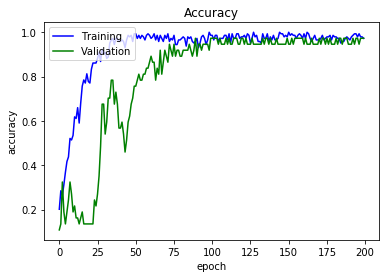

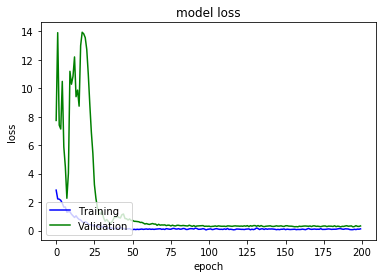

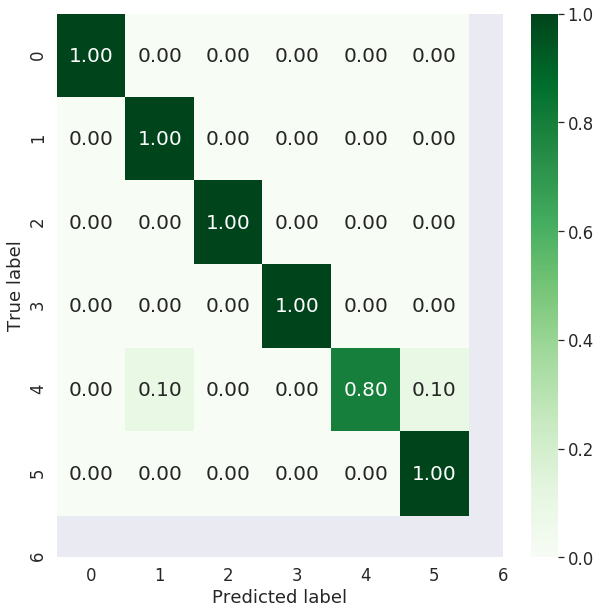

In [25]:
eval_model(cnn_history, cnn_model)

1/1 [==============================] - 0s 21ms/step
Evaluation loss:  0.5756271481513977
Evaluation accuracy:  0.7297297120094299


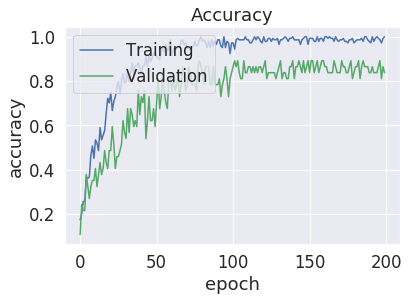

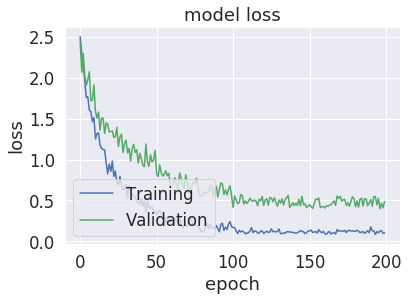

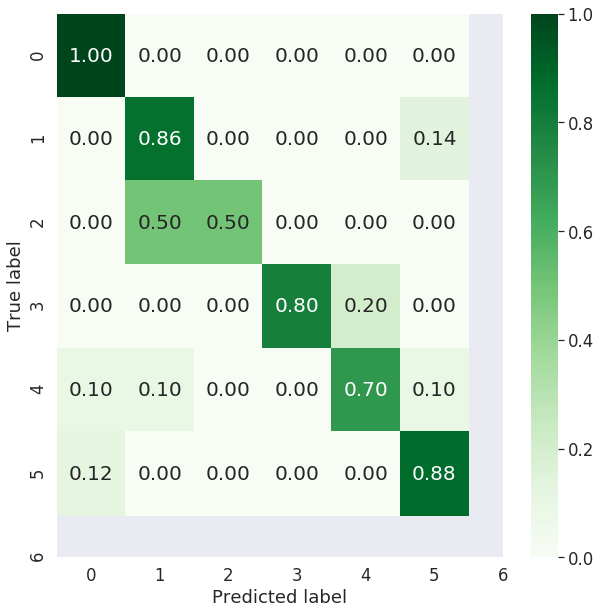

In [26]:
eval_model(nn_history, nn_model)